In [1]:
import cv2

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (10,6) 

In [4]:
img1 = cv2.imread('imgs/game-of-thrones-sansa-stark-pinup-models-pinup-vintage-tv-se.jpg')

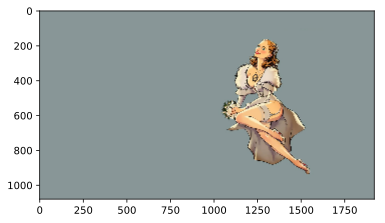

In [5]:
plot(img1)

In [6]:
img2 = cv2.imread('imgs/koshmas.png')

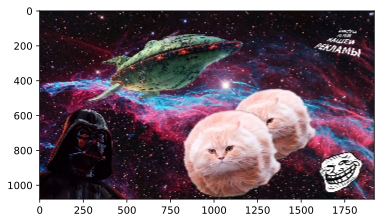

In [7]:
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
img2[-1,-1]

array([60, 33, 89], dtype=uint8)

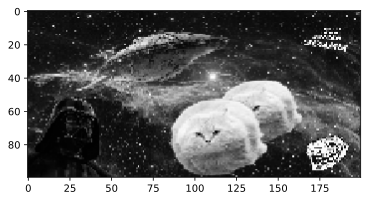

In [65]:
img3 = cv2.resize(img2,(200,100))
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
plot(img3)

In [10]:
def get_mean_color(img):
    return (np.sum(img, axis=(0,1)) / (img.shape[0] * img.shape[1])).astype(img.dtype)

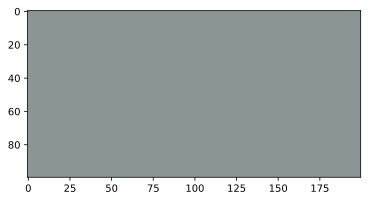

In [33]:
img4 = img3.copy()
img4[:,:] = get_mean_color(img1)
plot(img4)

In [12]:
def insert(img_to, img_what, x1, y1, x2, y2):
    w = x2-x1
    h = y2-y1
    img_resized = cv2.resize(img_what,(w,h))
    img_to[y1:y2, x1:x2, :] = img_resized[:,:,:]

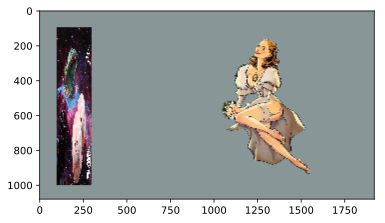

In [13]:
img4_copy = img1.copy()
insert(img4_copy, img2, 100, 100, 300, 1000)
plot(img4_copy)

In [14]:
get_mean_color(img3)

71

In [250]:
pix = np.array([60, 33, 200], dtype=np.uint8)
fac = 3
find_closest_palette_color(pix, fac), pix.astype(np.float) * fac

(array([ 85,   1, 170], dtype=uint8), array([180.,  99., 600.]))

In [394]:
%%writefile floyd_steinberg_dithering.py
import cv2
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

def plot(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
def insert_simple(img_to, img_what, x1, y1, x2, y2):
    w = x2-x1
    h = y2-y1
    if img_what.shape[0] != h or img_what.shape[1] != w:
        img_what = cv2.resize(img_what,(w,h))
    img_to[y1:y2, x1:x2] = img_what

@jit
def get_range(x_min, x_max, x1_min, x1_max, cen, cen1):
    dx1 = cen1 - x1_min
    res_min = cen - dx1
    if res_min < x_min:
        res_min = x_min
    res_min = int(res_min)
    res_max = res_min + (x1_max - x1_min)
    if res_max > x_max:
        res_max = x_max
        res_min = int(res_max - (x1_max - x1_min))
    res_max = int(res_max)
    return res_min, res_max
        
@jit
def get_paste_diaps(img_large, img_paste, center_large, center_paste, \
                    offset_large_x=0, offset_large_y=0):
    y_max_large, x_max_large, nope = img_large.shape
    y_max_paste, x_max_paste, nope = img_paste.shape
    
    x_max_large -= offset_large_x
    x_min_large = offset_large_x
    y_max_large -= offset_large_y
    y_min_large = offset_large_y
    
    x_p_min, x_p_max = get_range(x_min_large, x_max_large, 0, x_max_paste, 
                                 center_large[0], center_paste[0])
    y_p_min, y_p_max = get_range(y_min_large, y_max_large, 0, y_max_paste, 
                                 center_large[1], center_paste[1])
    return x_p_min, x_p_max, y_p_min, y_p_max 
    
@jit
def paste_with_mask(img_large, img_paste, mask_paste, center_large, center_paste):
    x1, x2, y1, y2 = get_paste_diaps(img_large, img_paste, center_large, center_paste)
    for i in range(y1,y2):
        for j in range(x1,x2):
            if mask_paste[i-y1, j-x1]:
                img_large[i,j,:] = img_paste[i-y1, j-x1,:]

@jit
def get_good_pix(pix):
    if isinstance(pix, np.ndarray):
        for i in range(pix.shape[0]):
            if pix[i] > 255:
                pix[i] = 255
            elif pix[i] < 0:
                pix[i] = 0
        return pix.astype(np.uint8)
    return 254 if pix > 254 else (1 if pix < 1 else int(pix))

@jit
def find_closest_palette_color(pix, factor):
    return get_good_pix(np.round(factor * pix.astype(np.float)/255.0) *(255.0/factor))

@jit
def kernel_fsd(img, error, x, y, dx, dy, multy, img_w, img_h):
    if x + dx < 0 or x+dx >= img_w or y+dy >= img_h:
        return
    img[y+dy, x+dx] = get_good_pix(img[y+dy, x+dx].astype(np.float) + error.astype(np.float) * multy)

@jit
def floyd_steinberg_dithering(img, factor=2):
    pixel = img.copy()
    if len(pixel.shape) == 2:
        pixel = np.reshape(pixel, (pixel.shape[0], pixel.shape[1], 1))
    img_h, img_w, r = pixel.shape
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            oldpixel = pixel[i,j].copy()
            newpixel = find_closest_palette_color(oldpixel, factor)
            pixel[i,j] = newpixel
            quant_error = get_good_pix(oldpixel.astype(np.float)  - newpixel.astype(np.float))  
            
            kernel_fsd(pixel, quant_error, j, i, 1, 0,  7/48, img_w, img_h)
            kernel_fsd(pixel, quant_error, j, i, 2, 0,  5/48, img_w, img_h)
            kernel_fsd(pixel, quant_error, j, i, -2, 1, 3/48, img_w, img_h)
            kernel_fsd(pixel, quant_error, j, i, -1, 1, 5/48, img_w, img_h)
            kernel_fsd(pixel, quant_error, j, i, 0,  1, 7/48, img_w, img_h)
            kernel_fsd(pixel, quant_error, j, i, 1,  1, 5/48, img_w, img_h)
            kernel_fsd(pixel, quant_error, j, i, 2,  1, 3/48, img_w, img_h)
            kernel_fsd(pixel, quant_error, j, i, -2, 2, 1/48, img_w, img_h)
            kernel_fsd(pixel, quant_error, j, i, -1, 2, 3/48, img_w, img_h)
            kernel_fsd(pixel, quant_error, j, i, 0,  2, 5/48, img_w, img_h)
            kernel_fsd(pixel, quant_error, j, i, 1,  2, 3/48, img_w, img_h)
            kernel_fsd(pixel, quant_error, j, i, 2,  2, 1/48, img_w, img_h)
    pixel = np.reshape(pixel, img.shape)
    return pixel

Overwriting floyd_steinberg_dithering.py


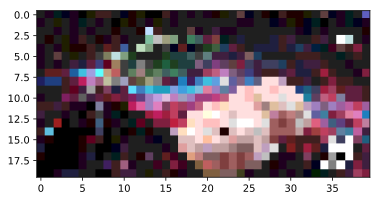

In [385]:
img5 =cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# plot(floyd_steinberg_dithering(cv2.resize(img3,(300,150)),4))
i = floyd_steinberg_dithering(cv2.resize(img2,(40,20)),8)
plot(i)

In [192]:
img1.shape

(1080, 1920, 3)

In [382]:
def img_likehood(img1, img2):
    if img1.shape != img2.shape:
        raise Exception(f'Картинки разного размера')
    if len(img1.shape) == 2:
        img1 = np.reshape(img1, (img1.shape[0], img1.shape[1], 1))
        img2 = np.reshape(img2, (img1.shape[0], img2.shape[1], 1))
    d =  img1.astype(np.float)-img2.astype(np.float)   
    return np.average(np.sqrt(np.sum(d*d, axis=2)))*100/255

In [383]:
d= img_likehood(cv2.resize(img2,(10,5)), floyd_steinberg_dithering(cv2.resize(img2,(10,5)),1))
d

31.428341381779816

In [378]:
np.average(np.sqrt(np.sum(d*d, axis=2)))

0.0